# SAT NETs for the AoA
August 2022

This notebook calculates NETs for a variety of SAT configurations, sited at the South Pole and in Chile, for comparision.  The model uses flat bands.

The model options are somewhat different now (August 2022) than back in June 2022, in that the aggressive models (high spillover) are generall more so, trying to mimic SO's aggressiveness.

Note that all the mapping speeds calculated here are for 18 tubes (==6 SATs).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import yaml
from jbolo_funcs import *

%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 8]


In [2]:
# List what yaml files you have so you can choose one for the next line.
!ls yamls 

CHLAT_20220807.yaml        SAT_baseline_20220507.yaml
S0_baseline_20220628.yaml  SAT_baseline_20220627.yaml
SAT_HWP_20220507.yaml      SAT_baseline_20220726.yaml
SAT_HWP_20220627.yaml      V3r7_Baseline_SAT_LF.yaml
SAT_HWP_20220726.yaml


In [3]:
# Dictionary of models to use, which includes yaml file and modifications
# Lists with values are ordered by frequency, [LF_1, LF_2, MF_1_1, MF_2_1, MF_!_2, MF_2_2, HF_1, HF_2]
SAT_models = {0:{},1:{},2:{},3:{}}
SAT_models[0]={
    'yaml':'SAT_baseline_20220726.yaml', # base yaml file to start with before mods
    'name':'Baseline, no HWP',
    'fnum' : 1.45,
    'ndet_pertube': [126,126, 1542,1776, 1542,1776, 5004,5004], # really horns/tube
    'ntubes':[2,2,6,6,6,6,4,4],   # 18 tubes
    'pixel_spacing':[31.0, 31.0, 9.4, 8.8, 9.4, 8.8, 5.2, 5.2], #mm
    'lyot_absorption': [.141,.079,0.162,0.141,0.065,0.079,0.06,0.02],  # HF should be lower, say [0.06, 0.02]
}

SAT_models[1]={
    'name':'Aggressive design, no HWP',
    'yaml':'SAT_baseline_20220726.yaml', # base yaml file to start with before mods
    'fnum' : 1.45,
    'ndet_pertube': [500,500, 4700, 5000, 4700,5000, 5000,5000], # LF, MF1, MF2, HF
    'ntubes':[2,2,6,6,6,6,4,4],   # 18 tubes
    'pixel_spacing':[15.7, 15.7, 5.3, 5.2, 5.3, 5.2, 5.2, 5.2], #mm
    'lyot_absorption': [0.64, 0.37, 0.623, 0.623, 0.295, 0.295, 0.06, 0.02],  # [LF_1, LF_2, MF1_1, MF2_1, MF1_2, MF2_2, HF_1, HF_2]
}

SAT_models[2]={
    'name':'Baseline scaled optics, with HWP',
    'yaml':'SAT_HWP_20220726.yaml', # base yaml file to start with before mods
    'fnum' : 1.45,
    'ndet_pertube': [81,81,1008,1170,1008,1170,3264,3264],
    'ntubes':[2,2,6,6,6,6,4,4],  # 18 tubes
    'pixel_spacing':[31.0, 31.0, 9.4, 8.8, 9.4, 8.8, 5.2, 5.2], #mm
    'lyot_absorption': [.141,.079,0.162,0.141,0.065,0.079,0.06,0.02],  # HF should be lower, say [0.06, 0.02]
}


SAT_models[3]={
    'name':'Aggressive design, with HWP',
    'yaml':'SAT_HWP_20220726.yaml', # base yaml file to start with before mods
    'fnum' : 1.845,
    'ndet_pertube': [280, 280, 3900, 3900, 3900, 3900, 5000, 5000],
    'ntubes':[2,2,6,6,6,6,4,4],
    'pixel_spacing':[20.7, 20.7, 5.8, 5.8, 5.8, 5.8, 5.3, 5.3], #mm
    'lyot_absorption': [0.64, 0.37, 0.623,  0.623, 0.295, 0.295, 0.08, 0.03],  
}


We're going to do this a very simple way, where we explicitly run each sim and plot it before moving on to the next.


In [4]:
models = [0,1,2,3]

site = 'Pole'  # Atacama or Pole
pwv = 321         # 321 or 993

# Run each model
for model in models:

    # Set up
    yamlfile = 'yamls/'+SAT_models[model]['yaml']
    sim = yaml.safe_load(open(yamlfile))
    sim['bolo_config']['f_number']= SAT_models[model]['fnum']
    sim['optical_elements']['lyot']['absorption']=SAT_models[model]['lyot_absorption']
    sim['sources']['atmosphere']['site']=site
    sim['sources']['atmosphere']['pwv']=pwv
    
    for ch in sim['channels'].keys():
        sim['channels'][ch]['pixel_spacing'] = 1e-3*SAT_models[model]['pixel_spacing'][sim['channels'][ch]['chnum']]
        sim['channels'][ch]['horn_diameter'] = sim['channels'][ch]['horn_diameter'] - 0.15e-3
        
    # Run
    run_optics(sim)
    run_bolos(sim)
 
    # Pack outputs into the models dictionary
    SAT_models[model]['channels']=sim['outputs'].keys()
    ii = 0
    for ch in SAT_models[model]['channels']:
        SAT_models[model][ch]={}
        net1det = 1e6*sim['outputs'][ch]['NET_C_total']
        ndet = SAT_models[model]['ndet_pertube'][ii]*SAT_models[model]['ntubes'][ii]
        net = net1det/np.sqrt(ndet)
        ms = 1/net**2
        SAT_models[model][ch]['mapping_speed'] = ms
        SAT_models[model][ch]['NET_C'] = net1det
        SAT_models[model][ch]['corr_factor'] = sim['outputs'][ch]['corr_factor']
        SAT_models[model][ch]['NET_NC']=1e6*sim['outputs'][ch]['NET_NC_total']
        ii += 1
        
# Print a table for each model
for model in models:
    print(SAT_models[model]['name'], end=', ')
    print(site, end=', ')
    print('pwv =',pwv,'u')
    print('            NET_NC     corr_fact NET_C mapping_speed  ms_ratio')
    for ch in SAT_models[model]['channels']:
        msratio = SAT_models[model][ch]['mapping_speed']/SAT_models[0][ch]['mapping_speed']
        print(ch.ljust(10),end='')
        print('{0:8.1f}  {1:8.3f} {2:8.1f}  {3:8.4f}  {4:8.1f}'.format(SAT_models[model][ch]['NET_NC'], SAT_models[model][ch]['corr_factor'],SAT_models[model][ch]['NET_C'],SAT_models[model][ch]['mapping_speed'],msratio ))
    print()
    
    

Baseline, no HWP, Pole, pwv = 321 u
            NET_NC     corr_fact NET_C mapping_speed  ms_ratio
LF_1         164.0     1.032    169.2    0.0088       1.0
LF_2         206.4     1.011    208.7    0.0058       1.0
MF_1_1       290.8     1.033    300.5    0.1024       1.0
MF_2_1       250.8     1.022    256.4    0.1621       1.0
MF_1_2       292.3     1.003    293.1    0.1077       1.0
MF_2_2       313.0     1.003    313.8    0.1082       1.0
HF_1         638.9     1.007    643.7    0.0483       1.0
HF_2        1554.0     1.001   1555.9    0.0083       1.0

Aggressive design, no HWP, Pole, pwv = 321 u
            NET_NC     corr_fact NET_C mapping_speed  ms_ratio
LF_1         214.8     1.152    247.4    0.0163       1.9
LF_2         220.0     1.030    226.6    0.0195       3.4
MF_1_1       348.5     1.055    367.7    0.2086       2.0
MF_2_1       310.3     1.016    315.4    0.3016       1.9
MF_1_2       313.8     1.026    322.1    0.2718       2.5
MF_2_2       335.4     1.020    342.1 

# Make a plot of these mapping speeds

# NET vs pwv 

Calculate and print NET as f(pwv) to a toml file, 
different toml file for each option.

We want to set Psat to the value designed for (elev0, pwv0), then keep it fixed after that.

In [42]:
elev0 = 50 # degrees

models = [0,1,2,3]
pwv0_dict = {'Pole':321, 'Atacama':993}
psat0_dict = {}
for site in ['Pole','Atacama']:
    print(site)
    pwv0 = pwv0_dict[site]
    output_dict = {}
    for model in models:

        print(model)
        toml_output_file = 'SAT_NET_v_pwv_'+site+'_model_'+str(model)+'.toml'

        # Set up the sim dictionary correctly given the model we're using
        yamlfile = 'yamls/'+SAT_models[model]['yaml']
        sim = yaml.safe_load(open(yamlfile))
        sim['bolo_config']['f_number']= SAT_models[model]['fnum']
        sim['optical_elements']['lyot']['absorption']=SAT_models[model]['lyot_absorption']
        sim['sources']['atmosphere']['site']=site
        sim['sources']['atmosphere']['pwv']=pwv0
        sim['sources']['atmosphere']['elevation'] = elev0

        chlist = sim['channels'].keys()
        for ch in chlist:
            sim['channels'][ch]['pixel_spacing'] = 1e-3*SAT_models[model]['pixel_spacing'][sim['channels'][ch]['chnum']]
            sim['channels'][ch]['horn_diameter'] = sim['channels'][ch]['horn_diameter'] - 0.15e-3

        # run once to set Psats
        psat0_dict.clear()  # clear this for each new model
        run_optics(sim)  
        run_bolos(sim)
        for ch in chlist:
            psat0_dict[ch]=sim['outputs'][ch]['P_sat']
        
        # pwv's we want to calculate for
        pwv_vec = np.arange(0,5000,100)

        # Start setting up the output dictionary
        output_dict.clear()
        output_dict['model_name'] = SAT_models[model]['name']
        output_dict['pwv']=pwv_vec
        output_dict['elevation']=elev0
        output_dict['site']=site
        for ch in chlist:
            output_dict[ch] = {}
            output_dict[ch]['NET_NC']=np.array([])
            output_dict[ch]['corr_factor']=np.array([])
            #output_dict[ch]['psat']=psat0_dict[ch]
            

        # Run jbolo in a loop to fill in the pwv-dependent variables in that dictionary
        for pwv in pwv_vec:
            
            # Clear previous iteration results so things don't multiply.
            if 'outputs' in sim.keys():  
                sim['outputs'].clear()  

            # Fixed psat, ie same one every time.
            sim['bolo_config']['method']='specified'
            for ch in chlist:
                sim['channels'][ch]['psat']=psat0_dict[ch]
            
            # New value of pwv
            sim['sources']['atmosphere']['pwv']=pwv    
            
            # run jbolo
            run_optics(sim)
            run_bolos(sim)

            # save pwv-dependent outputs
            for ch in chlist:
                output_dict[ch]['NET_NC']     =np.append(output_dict[ch]['NET_NC'],     sim['outputs'][ch]['NET_NC_total'])
                output_dict[ch]['corr_factor']=np.append(output_dict[ch]['corr_factor'],sim['outputs'][ch]['corr_factor' ])

        with open(toml_output_file, "w") as toml_file:
            toml.dump(output_dict, toml_file, encoder=toml.TomlNumpyEncoder())


Pole
0
1
2
3
Atacama
0
1
2
3


In [41]:
output_dict

{'model_name': 'Baseline, no HWP',
 'pwv': array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
        1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
        2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
        3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300,
        4400, 4500, 4600, 4700, 4800, 4900]),
 'elevation': 50,
 'site': 'Pole',
 'LF_1': {'NET_NC': array([0.00015926, 0.00016074, 0.00016216, 0.00016366, 0.00016509,
         0.0001666 , 0.00016805, 0.00016957, 0.00017104, 0.00017257,
         0.00017405, 0.00017559, 0.00017708, 0.00017863, 0.00018013,
         0.0001817 , 0.00018321, 0.00018478, 0.00018637, 0.00018789,
         0.00018948, 0.00019101, 0.00019262, 0.00019416, 0.00019577,
         0.00019732, 0.00019894, 0.0002005 , 0.00020213, 0.00020369,
         0.00020533, 0.0002069 , 0.00020855, 0.00021013, 0.00021178,
         0.00021344, 0.00021503, 0.0002167 , 0.0002183 , 0.00021997,
         0.

# Plot NET vs pwv results

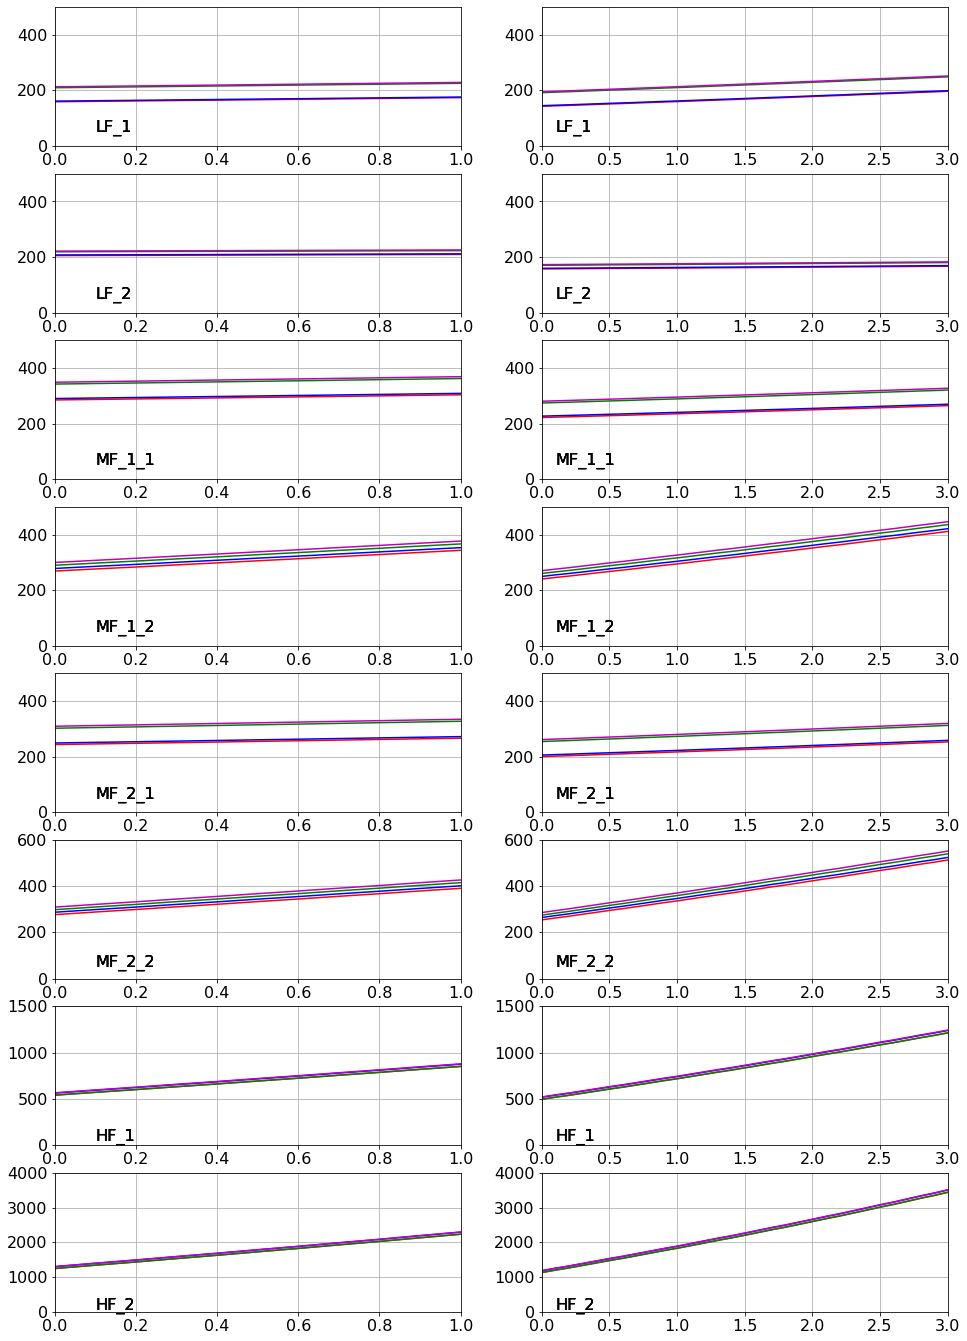

In [27]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [16, 24]

# Read toml_file
filedir = 'Results_20220912/'

channels = ['LF_1', 'LF_2', 'MF_1_1', 'MF_1_2', 'MF_2_1', 'MF_2_2', 'HF_1', 'HF_2']
fig,axs = plt.subplots(8,2)

lcolor={0:'r',1:'g',2:'b',3:'m'}
models = [0,1,2,3]


for model in models:
    toml_input_file = filedir+'SAT_NET_v_pwv_Pole_model_'+str(model)+'.toml'
    with open(toml_input_file, "r") as toml_file:
        Poledata = toml.load(toml_file)
        
    toml_input_file = filedir+'SAT_NET_v_pwv_Atacama_model_'+str(model)+'.toml'
    with open(toml_input_file, "r") as toml_file:
        Atacamadata = toml.load(toml_file)

    ii = 0
    for ch in channels:
        axs[ii][0].plot(np.array(Poledata['pwv'])/1000,np.array(Poledata[ch]['NET_NC'])*1.0e6, color = lcolor[model])
        axs[ii][1].plot(np.array(Atacamadata['pwv'])/1000,np.array(Atacamadata[ch]['NET_NC'])*1.0e6, color = lcolor[model])
        axs[ii][0].text(0.1,50,ch)
        axs[ii][1].text(0.1,50,ch)
        ii += 1

for ii in np.arange(8):
    axs[ii][0].set_ylim(0)
    axs[ii][0].set_xlim(0,1)
    axs[ii][0].grid()
    axs[ii][1].set_ylim(0)
    axs[ii][1].set_xlim(0,3)
    axs[ii][1].grid()
    
for col in [0,1]:
    axs[0][col].set_ylim(0,500)
    axs[1][col].set_ylim(0,500)
    axs[2][col].set_ylim(0,500)
    axs[3][col].set_ylim(0,500)
    axs[4][col].set_ylim(0,500)
    axs[5][col].set_ylim(0,600)
    axs[6][col].set_ylim(0,1500)
    axs[7][col].set_ylim(0,4000)
    

In [31]:
sim.keys()

dict_keys(['version', 'config', 'sources', 'optics_defaults', 'optical_elements', 'bolo_config', 'readout', 'channels', 'outputs'])

# NET vs elevation

In [32]:
elev0 = 50 # degrees

models = [0,1,2,3]
pwv0_dict = {'Pole':321, 'Atacama':993}

for site in ['Pole','Atacama']:
    print(site)
    pwv0 = pwv0_dict[site]
    output_dict = {}
    for model in models:
        print(model)
        toml_output_file = 'SAT_NET_v_elev_'+site+'_model_'+str(model)+'.toml'

        # Set up the sim dictionary correctly given the model we're using
        yamlfile = 'yamls/'+SAT_models[model]['yaml']
        sim = yaml.safe_load(open(yamlfile))
        sim['bolo_config']['f_number']= SAT_models[model]['fnum']
        sim['optical_elements']['lyot']['absorption']=SAT_models[model]['lyot_absorption']
        sim['sources']['atmosphere']['site']=site
        sim['sources']['atmosphere']['pwv']=pwv0
        sim['sources']['atmosphere']['elevation'] = elev0
        
        for ch in sim['channels'].keys():
            sim['channels'][ch]['pixel_spacing'] = 1e-3*SAT_models[model]['pixel_spacing'][sim['channels'][ch]['chnum']]
            sim['channels'][ch]['horn_diameter'] = sim['channels'][ch]['horn_diameter'] - 0.15e-3



        # pwv's we want to calculate for
        elev_vec = np.arange(20,70,1)

        # Start setting up the output dictionary
        output_dict.clear()
        output_dict['model_name'] = SAT_models[model]['name']
        output_dict['pwv']=pwv0
        output_dict['elevation']=elev_vec
        output_dict['site']=site
        
        chlist = sim['channels'].keys()
        for ch in chlist:
            output_dict[ch] = {}
            output_dict[ch]['NET_NC']=np.array([])
            output_dict[ch]['corr_factor']=np.array([])

        # Run jbolo in a loop to fill that dictionary
        for elev in elev_vec:
            if 'outputs' in sim.keys():  
                sim['outputs'].clear()  # Clear previous iteration results so things don't multiply.

            sim['sources']['atmosphere']['elevation']=elev
            run_optics(sim)
            run_bolos(sim)

            for ch in chlist:
                output_dict[ch]['NET_NC']     =np.append(output_dict[ch]['NET_NC'],     sim['outputs'][ch]['NET_NC_total'])
                output_dict[ch]['corr_factor']=np.append(output_dict[ch]['corr_factor'],sim['outputs'][ch]['corr_factor' ])

        with open(toml_output_file, "w") as toml_file:
            toml.dump(output_dict, toml_file, encoder=toml.TomlNumpyEncoder())


Pole
0
1
2
3
Atacama
0
1
2
3


# Plot NET vs elevation 
(from toml file)

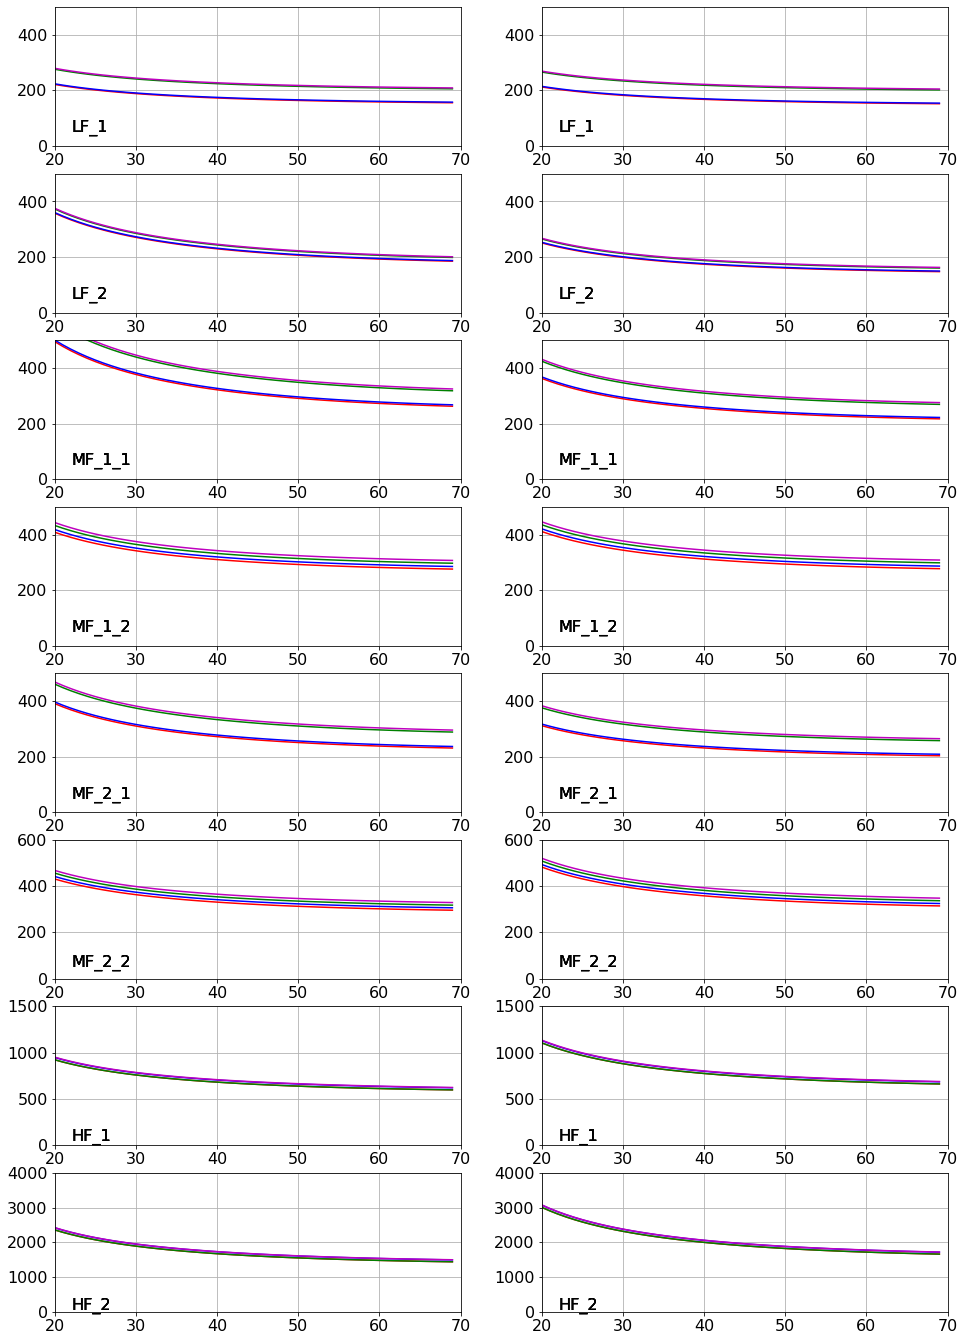

In [43]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [16, 24]

# Read toml_file
filedir = 'Results_20220912/'

channels = ['LF_1', 'LF_2', 'MF_1_1', 'MF_1_2', 'MF_2_1', 'MF_2_2', 'HF_1', 'HF_2']
fig,axs = plt.subplots(8,2)

lcolor={0:'r',1:'g',2:'b',3:'m'}
models = [0,1,2,3]


for model in models:
    toml_input_file = filedir+'SAT_NET_v_elev_Pole_model_'+str(model)+'.toml'
    with open(toml_input_file, "r") as toml_file:
        Poledata = toml.load(toml_file)
        
    toml_input_file = filedir+'SAT_NET_v_elev_Atacama_model_'+str(model)+'.toml'
    with open(toml_input_file, "r") as toml_file:
        Atacamadata = toml.load(toml_file)

    ii = 0
    for ch in channels:
        axs[ii][0].plot(np.array(Poledata['elevation']),np.array(Poledata[ch]['NET_NC'])*1.0e6, color = lcolor[model])
        axs[ii][1].plot(np.array(Atacamadata['elevation']),np.array(Atacamadata[ch]['NET_NC'])*1.0e6, color = lcolor[model])
        axs[ii][0].text(22,50,ch)
        axs[ii][1].text(22,50,ch)
        ii += 1

for ii in np.arange(8):
    axs[ii][0].set_ylim(0)
    axs[ii][0].set_xlim(20,70)
    axs[ii][0].grid()
    axs[ii][1].set_ylim(0)
    axs[ii][1].set_xlim(20,70)
    axs[ii][1].grid()
    
for col in [0,1]:
    axs[0][col].set_ylim(0,500)
    axs[1][col].set_ylim(0,500)
    axs[2][col].set_ylim(0,500)
    axs[3][col].set_ylim(0,500)
    axs[4][col].set_ylim(0,500)
    axs[5][col].set_ylim(0,600)
    axs[6][col].set_ylim(0,1500)
    axs[7][col].set_ylim(0,4000)
    

In [10]:
ls *.toml

SAT_NET_v_elev_Atacama_option_0.toml  SAT_NET_v_pwv_Atacama_option_0.toml
SAT_NET_v_elev_Atacama_option_1.toml  SAT_NET_v_pwv_Atacama_option_1.toml
SAT_NET_v_elev_Atacama_option_2.toml  SAT_NET_v_pwv_Atacama_option_2.toml
SAT_NET_v_elev_Atacama_option_3.toml  SAT_NET_v_pwv_Atacama_option_3.toml
SAT_NET_v_elev_Pole_option_0.toml     SAT_NET_v_pwv_Pole_option_0.toml
SAT_NET_v_elev_Pole_option_1.toml     SAT_NET_v_pwv_Pole_option_1.toml
SAT_NET_v_elev_Pole_option_2.toml     SAT_NET_v_pwv_Pole_option_2.toml
SAT_NET_v_elev_Pole_option_3.toml     SAT_NET_v_pwv_Pole_option_3.toml


# Below here we're plotting June 2022 results, which is same baseline model as September 2022 results.

# Compare option 0 with PBDR_v2 results

Looking through yaml files, changes include (new vs old):
- window is 2cm (new) rather than 3cm thick (old)
- HF lenses are HDPE (new) rather than silicon (old)
- cold (lyot) stop absorptions are calculated by SAT group/Sara Simons, rather than Gaussian approximation
- f/# is 1.45 (new) rather than 1.55 (old).  This should only affect the old calc of cold stop spillover.
- both are flat bands, but edges specified in different ways (edges for new, center + fractional bandwidth for old), leading to very small band edge differences (order 0.1GHz at most in band center and 0.001 or so in fractional bandwidth, typically much less than these).


Text(0.5, 0.98, 'SAT Single-detector NET vs pwv (Pole baseline)')

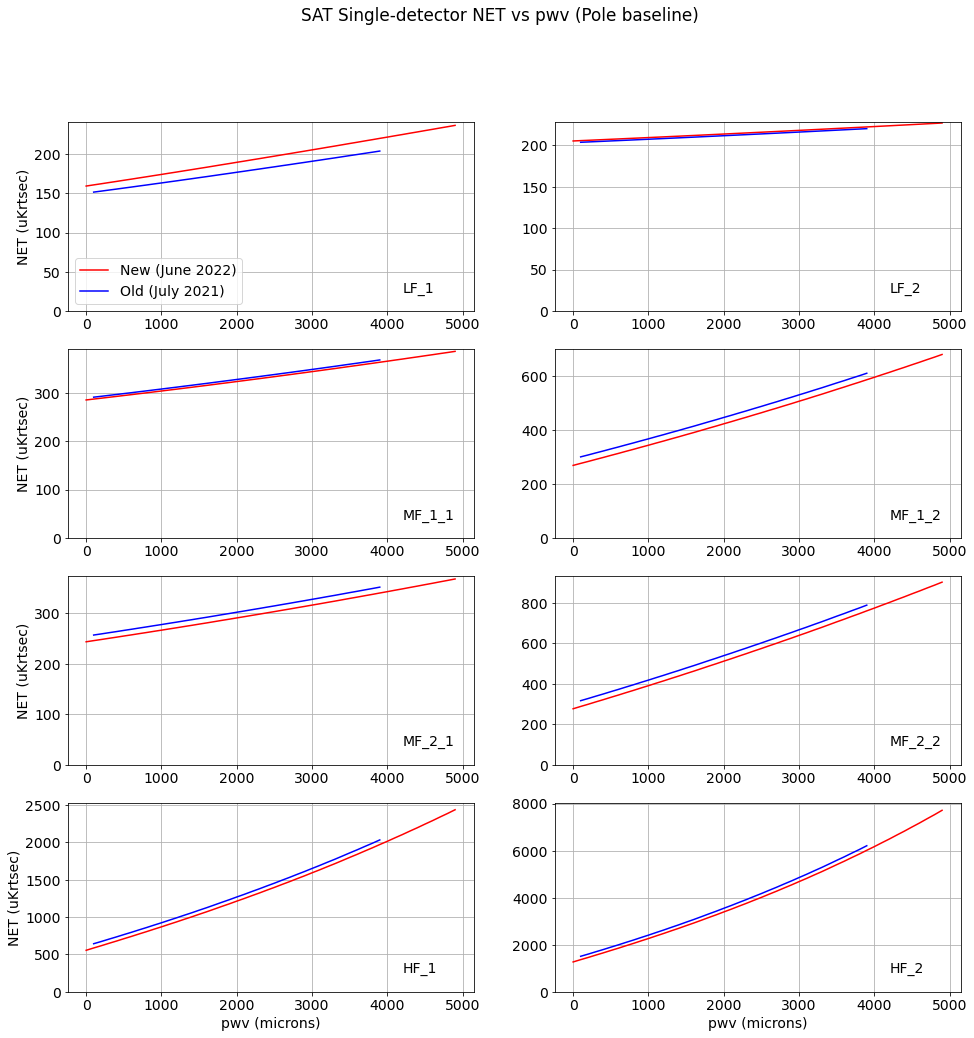

In [93]:
option = 0
newtubes = ['LF', 'MF_1', 'MF_2', 'HF']
oldtubes = ['LF', 'MF1', 'MF2', 'HF']
fig,axs = plt.subplots(4,2)

lcolor={0:'r',1:'g',2:'b',3:'m'}
lstyle = {'Atacama':'--','Pole':'-'}

filedir = 'Results_20220628/'

for site in ['Pole']:
    toml_input_file_new = filedir+'SAT_NET_v_pwv_'+site+'_option_'+str(option)+'.toml'
    labelstr = site
    with open(toml_input_file_new, "r") as toml_file:
        data_new = toml.load(toml_file)
            
    toml_input_file_old = '../../bolo-calc/pbdr_v2/outputs_july27/NET_v_pwv.toml'
    with open(toml_input_file_old, "r") as toml_file:
        data_old = toml.load(toml_file) 
    for ii in np.arange(4):
        ch = newtubes[ii] + '_1'
        axs[ii][0].plot(data_new['pwv'],np.array(data_new[ch]['NET_NC'])*1.0e6,linestyle = lstyle[site],color='r',label='New (June 2022)')
        ch = newtubes[ii] + '_2'
        axs[ii][1].plot(data_new['pwv'],np.array(data_new[ch]['NET_NC'])*1.0e6,linestyle = lstyle[site],color='r',label='New (June 2022)')

        if oldtubes[ii]=='HF':
            ch = oldtubes[ii] + '_1'
            axs[ii][0].plot(data_old["SAT_HF_20210714.yaml"][ch]['pwv'],np.array(data_old["SAT_HF_20210714.yaml"][ch]['NET']),linestyle = lstyle[site],color='blue',label='Old (July 2021)')
            ch = oldtubes[ii] + '_2'
            axs[ii][1].plot(data_old["SAT_HF_20210714.yaml"][ch]['pwv'],np.array(data_old["SAT_HF_20210714.yaml"][ch]['NET']),linestyle = lstyle[site],color='blue',label='Old (July 2021)')
        else:
            ch = oldtubes[ii] + '_1'
            axs[ii][0].plot(data_old['SAT_LFMF_20210714.yaml'][ch]['pwv'],np.array(data_old['SAT_LFMF_20210714.yaml'][ch]['NET']),linestyle = lstyle[site],color='blue',label='Old (July 2021)')
            ch = oldtubes[ii] + '_2'
            axs[ii][1].plot(data_old["SAT_LFMF_20210714.yaml"][ch]['pwv'],np.array(data_old["SAT_LFMF_20210714.yaml"][ch]['NET']),linestyle = lstyle[site],color='blue',label='Old (July 2021)')

        ii +=1
        
for ii in np.arange(4):
    axs[ii][0].set_ylim(0)
    axs[ii][0].grid()
    axs[ii][1].set_ylim(0)
    axs[ii][1].grid()
    axs[ii][0].set_ylabel('NET (uKrtsec)')
    

axs[3][0].set_xlabel('pwv (microns)')
axs[3][1].set_xlabel('pwv (microns)')
axs[0][0].legend(loc='lower left')

ii = 0
for tube in tubes:
    aa = axs[ii][0].get_ylim()
    bb = axs[ii][1].get_ylim()
    axs[ii][0].text(4200,aa[1]/10,tube+'_1')
    axs[ii][1].text(4200,bb[1]/10,tube+'_2')
    ii += 1

fig.suptitle('SAT Single-detector NET vs pwv (Pole baseline)')


# Compare option 0 with PBDR_v3 results

Looking through yaml files, changes include (new vs old):

- window is 2cm (new) rather than 3cm thick (old)
- HF lenses are HDPE (new) rather than silicon (old)
- cold (lyot) stop absorptions are taken from Paul Grimes' spreadsheet, which sets:
  - MF1 as calculated by SAT group/Sara Simons, new is same as old, 
  - LF and HF set to be same as MF1, rather than gaussian approximations (old),
  - MF2 calculated by SAT group/Sara Simons, but revised numbers from old version in MF2_1 (from 0.125 to 0.141)
- f/# is 1.45 (new) rather than 1.55 (old). This should only affect the old calc of cold stop spillover in cases where the gaussian approximation is used.

Both are flat bands, but edges specified in different ways (edges for new, center + fractional bandwidth for old), leading to very small band edge differences (order 0.1GHz at most in band center and 0.001 or so in fractional bandwidth, typically much less than these).

Running with same window thickness shows nearly identical results at LF, MF.  HF slightly different still, presumably due to different spillover calc on cold stop.

Text(0.5, 0.98, 'SAT Single-detector NET vs pwv (Pole baseline)')

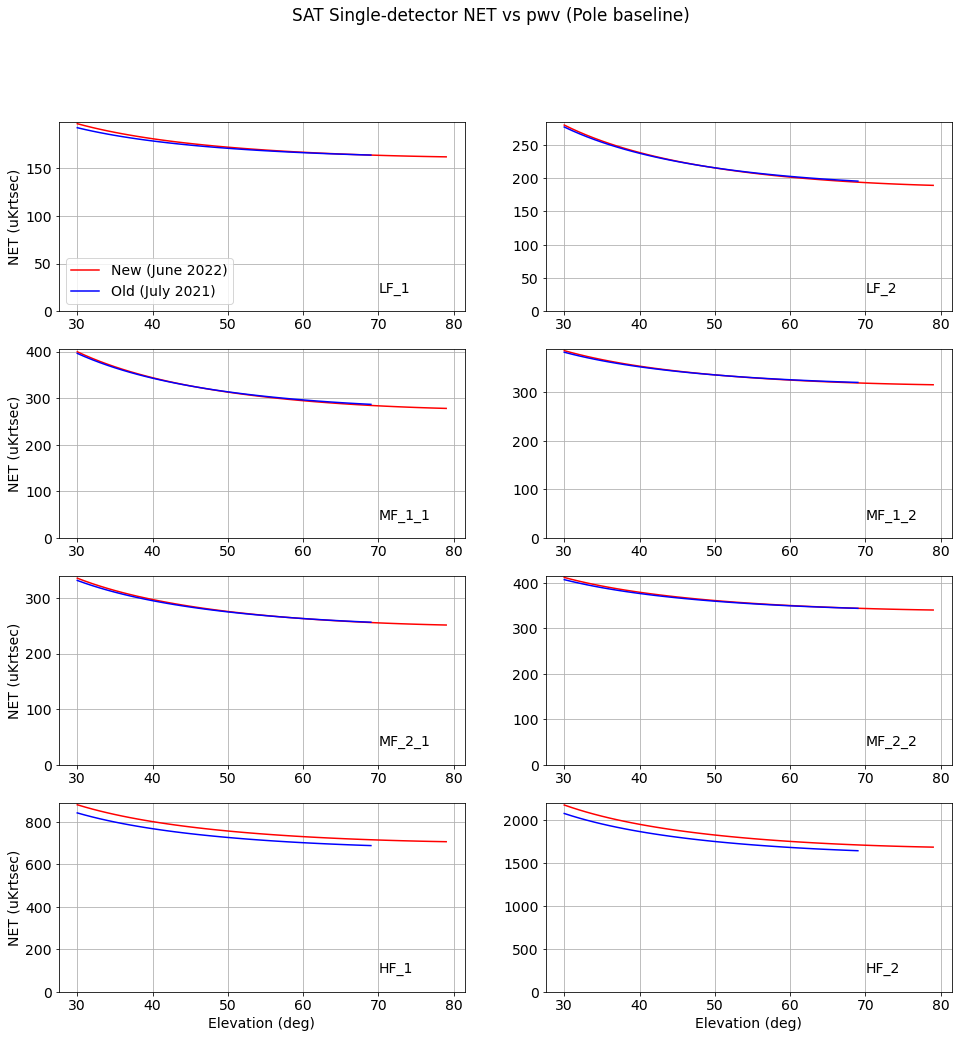

In [92]:
option = 0
newtubes = ['LF', 'MF_1', 'MF_2', 'HF']
oldtubes = ['LF', 'MF1', 'MF2', 'HF']
fig,axs = plt.subplots(4,2)

lcolor={0:'r',1:'g',2:'b',3:'m'}
lstyle = {'Atacama':'--','Pole':'-'}

filedir = 'Results_20220628/'

for site in ['Pole']:
    toml_input_file_new = filedir+'SAT_NET_v_elev_'+site+'_option_'+str(option)+'.toml'
    labelstr = site
    with open(toml_input_file_new, "r") as toml_file:
        data_new = toml.load(toml_file)
            
    toml_input_file_old = '../../bolo-calc/pbdr_v3/outputs/NET_v_elevation.toml'
    with open(toml_input_file_old, "r") as toml_file:
        data_old = toml.load(toml_file) 
    for ii in np.arange(4):
        ch = newtubes[ii] + '_1'
        axs[ii][0].plot(data_new['elev'],np.array(data_new[ch]['NET_NC'])*1.0e6,linestyle = lstyle[site],color='r',label='New (June 2022)')
        ch = newtubes[ii] + '_2'
        axs[ii][1].plot(data_new['elev'],np.array(data_new[ch]['NET_NC'])*1.0e6,linestyle = lstyle[site],color='r',label='New (June 2022)')

        if oldtubes[ii]=='HF':
            ch = oldtubes[ii] + '_1'
            axs[ii][0].plot(data_old["SAT_HF_20210714.yaml"][ch]['elevation'],np.array(data_old["SAT_HF_20210714.yaml"][ch]['NET']),linestyle = lstyle[site],color='blue',label='Old (July 2021)')
            ch = oldtubes[ii] + '_2'
            axs[ii][1].plot(data_old["SAT_HF_20210714.yaml"][ch]['elevation'],np.array(data_old["SAT_HF_20210714.yaml"][ch]['NET']),linestyle = lstyle[site],color='blue',label='Old (July 2021)')
        elif (oldtubes[ii]=='MF1' or oldtubes[ii]=='MF2'):
            ch = oldtubes[ii] + '_1'
            axs[ii][0].plot(data_old['SAT_MF_20211015.yaml'][ch]['elevation'],np.array(data_old['SAT_MF_20211015.yaml'][ch]['NET']),linestyle = lstyle[site],color='blue',label='Old (July 2021)')
            ch = oldtubes[ii] + '_2'
            axs[ii][1].plot(data_old["SAT_MF_20211015.yaml"][ch]['elevation'],np.array(data_old["SAT_MF_20211015.yaml"][ch]['NET']),linestyle = lstyle[site],color='blue',label='Old (July 2021)')
        elif oldtubes[ii]=='LF':
            ch = oldtubes[ii] + '_1'
            axs[ii][0].plot(data_old['SAT_LF_20211015.yaml'][ch]['elevation'],np.array(data_old['SAT_LF_20211015.yaml'][ch]['NET']),linestyle = lstyle[site],color='blue',label='Old (July 2021)')
            ch = oldtubes[ii] + '_2'
            axs[ii][1].plot(data_old["SAT_LF_20211015.yaml"][ch]['elevation'],np.array(data_old["SAT_LF_20211015.yaml"][ch]['NET']),linestyle = lstyle[site],color='blue',label='Old (July 2021)')
        else:
            print('tube error')
        
        ii +=1
        
for ii in np.arange(4):
    axs[ii][0].set_ylim(0)
    axs[ii][0].grid()
    axs[ii][1].set_ylim(0)
    axs[ii][1].grid()
    axs[ii][0].set_ylabel('NET (uKrtsec)')
    

axs[3][0].set_xlabel('Elevation (deg)')
axs[3][1].set_xlabel('Elevation (deg)')
axs[0][0].legend(loc='lower left')

ii = 0
for tube in tubes:
    aa = axs[ii][0].get_ylim()
    bb = axs[ii][1].get_ylim()
    axs[ii][0].text(70,aa[1]/10,tube+'_1')
    axs[ii][1].text(70,bb[1]/10,tube+'_2')
    ii += 1

fig.suptitle('SAT Single-detector NET vs pwv (Pole baseline)')


In [89]:
sim['optical_elements']['window']['thickness']

0.02

In [78]:
data_old['SAT_LF_20211015.yaml'].keys()

dict_keys(['LF_1', 'LF_2'])

# SO design
Calculate NETs for the SO design, with similar assumptions to S4, and compare to the S4 baseline.

In [103]:
ls yamls

S0_baseline_20220628.yaml   SAT_baseline_20220507.yaml
SAT_HWP_20220507.yaml       SAT_baseline_20220627.yaml
SAT_HWP_20220627.yaml


In [138]:
def printtable(sim):
    print('Channel     Lyot_eff. optics_eff   P_opt   NET_C_1det  NET_wafer')
    for ch in sim['outputs'].keys():
        lyoteffic = np.mean(sim['outputs'][ch]['optics']['lyot']['effic'])
        effic = np.mean(sim['outputs'][ch]['optics_effic_total'])
        popt = 1e12*sim['outputs'][ch]['P_opt']
        net1det = 1e6*sim['outputs'][ch]['NET_C_total']
        ndet = sim['channels'][ch]['num_det_per_wafer']
        net = net1det/np.sqrt(ndet)
        print('{0:9s}:  {1:8.2f}  {2:8.2f}  {3:8.2f} {4:8.2f} {5:8.2f} '.format(ch, lyoteffic, effic, popt, net1det, net))
    print()

    
###### Run SO
print('SO baseline')
sim = yaml.safe_load(open('yamls/S0_baseline_20220628.yaml'))
run_optics(sim)
run_bolos(sim)
printtable(sim)


print('S4 baseline')
sim = yaml.safe_load(open('yamls/SAT_baseline_20220627.yaml'))
run_optics(sim)
run_bolos(sim)
printtable(sim)


print('S4 baseline, wide MF1')
sim = yaml.safe_load(open('yamls/SAT_baseline_20220627.yaml'))
sim['channels']['MF_1_1']['nu_low'] = 74.8       
sim['channels']['MF_1_1']['nu_high'] = 108.7
sim['channels']['MF_1_2']['nu_low'] = 126.7       
sim['channels']['MF_1_2']['nu_high'] = 167.3
run_optics(sim)
run_bolos(sim)
printtable(sim)

SO baseline
Channel     Lyot_eff. optics_eff   P_opt   NET_C_1det  NET_wafer
LF_1     :      0.36      0.26      0.24   274.78    31.94 
LF_2     :      0.73      0.52      1.53   219.34    25.50 
MF_1     :      0.38      0.27      1.64   279.16     9.52 
MF_2     :      0.70      0.49      2.85   251.04     8.56 
HF_1     :      0.92      0.62      7.30   512.43    17.47 
HF_2     :      0.97      0.64     10.04  1227.76    41.87 

S4 baseline
Channel     Lyot_eff. optics_eff   P_opt   NET_C_1det  NET_wafer
LF_1     :      0.86      0.73      0.57   169.23    34.54 
LF_2     :      0.92      0.77      2.32   208.68    42.60 
MF_1_1   :      0.84      0.67      3.00   299.28    17.45 
MF_2_1   :      0.86      0.68      2.93   255.31    14.89 
MF_1_2   :      0.94      0.70      4.38   292.85    17.08 
MF_2_2   :      0.92      0.69      4.66   313.60    18.29 
HF_1     :      0.86      0.58      9.34   658.44    21.50 
HF_2     :      0.92      0.56     11.94  1580.50    51.61 

S4 b

In [114]:
sim['outputs'][ch].keys()

dict_keys(['optics', 'sources', 'nu', 'det_bandwidth', 'det_bandcenter', 'sys_bandwidth', 'sys_bandcenter', 'optics_effic_total', 'optics_Pnu_total', 'sky_bandwidth', 'sky_bandcenter', 'P_opt', 'Pnu_total', 'det_pitch_flam', 'aperture_factor', 'stop_factor', 'NEP_photonNC', 'NEP_photon_poissonNC', 'NEP_photon_boseNC', 'NEP_photonNC_v2', 'NEP_photon_poissonNC_v2', 'NEP_photon_boseNC_v2', 'n_avg', 'NEP_photonC', 'NEP_photon_poissonC', 'NEP_photon_boseC', 'dpdt', 'P_sat', 'P_elec', 'G_dynamic', 'F_link', 'NEP_phonon', 'loopgain', 'S_I', 'NEP_J_bolo', 'NEP_J_shunt', 'NEP_J_tot', 'NEP_readout', 'NEP_NC_total', 'NEP_C_total', 'corr_factor', 'NET_NC_total', 'NET_C_total', 'NET_C_wafer', 'NET_NC_wafer'])

In [133]:
sim['outputs'][ch]['optics']['lyot']['effic']

array([0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921,
       0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921,
       0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921,
       0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921,
       0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921,
       0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921,
       0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921,
       0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921,
       0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921,
       0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921,
       0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921,
       0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921,
       0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921,
       0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921, 0.921,
       0.921, 0.921,